# Equação de Calor
----

## Bibliotecas

Utilizaremos o DeepXDE junto com PyTorch para resolver estas equações.

In [1]:
import torch
import deepxde as dde
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Para reprodução dos experimentos
dde.config.set_random_seed(1000)

## Modelo equação de calor

$$
\frac{\partial u}{\partial t}(x,t) - \alpha \frac{\partial^2 u}{\partial x^2}(x,t) = f(x,t), \quad x \in (0,\ell), \ t> 0
$$

In [3]:
a = 1

In [4]:
def pde(x, y):
    dy_dt = dde.grad.jacobian(y, x, i=0, j=1)
    dy_dxx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_dt - a * dy_dxx

## Limites

$$
x \in (0,\ell), \ t> 0
$$

In [5]:
L = 1
n = 1

In [6]:
t0, tf = 0, 1

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(t0, tf)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Condições de contorno e iniciais

In [7]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

## Solução Exata

$$
u(x,t) = e^{\frac{-\alpha \pi^2 t}{\ell}} \sin \Big( \frac{\pi x}{\ell} \Big)
$$

In [8]:
def exact_solution(X):
    x, t = X[:,0], X[:,1]
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

## Dados de treinamento

In [9]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2500,
    num_boundary=80,
    num_initial=160,
    num_test=150
)

## Otimizando a rede

In [27]:
n_hidden_layers = [1, 2, 3, 4, 5, 6]
n_nodes_per_layer = [10, 20, 40]

# n_hidden_layers = [1]
# n_nodes_per_layer = [10]

In [28]:
def create_test_points(nop):
    
    X = np.linspace(0, L, nop)
    Y = np.linspace(t0, tf, nop)
    
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack((X.flatten(), Y.flatten())).T

    return X, Y, XY

In [29]:
nop = 50
_, _, test_points = create_test_points(nop)

table = []

for n_hidden_l in n_hidden_layers:
    for n_nodes in n_nodes_per_layer:
        
        net = dde.nn.FNN([2] + [n_nodes] * n_hidden_l + [1], "tanh", "Glorot normal")
        model = dde.Model(data, net)
        
        model.compile("adam", lr=1e-3)
    
        losshistory, train_state = model.train(
            iterations=20000, 
            model_save_path=f"../modelos/heat_{n_nodes}x{n_hidden_l}")

        exact = exact_solution(test_points).reshape((nop, nop))
        pinns = model.predict(test_points).reshape((nop, nop))

        print(scipy.linalg.norm(exact - pinns, ord=np.inf))
        print(np.max(np.abs(pinns - exact)))
        
        #l_infinity = scipy.linalg.norm(exact - pinns, ord=np.inf)
        l_infinity = np.max(np.abs(pinns - exact))
        
        table.append([n_hidden_l, n_nodes, l_infinity])
 

Compiling model...
'compile' took 0.000149 s

Training model...

0         [1.30e-01, 1.93e-01, 2.69e-01]    [1.29e-01, 1.93e-01, 2.69e-01]    []  
1000      [4.52e-03, 4.95e-02, 8.58e-02]    [2.97e-03, 4.95e-02, 8.58e-02]    []  
2000      [5.80e-03, 4.07e-02, 7.23e-02]    [4.80e-03, 4.07e-02, 7.23e-02]    []  
3000      [5.40e-03, 2.44e-02, 5.63e-02]    [3.08e-03, 2.44e-02, 5.63e-02]    []  
4000      [7.88e-03, 1.18e-02, 3.42e-02]    [5.03e-03, 1.18e-02, 3.42e-02]    []  
5000      [7.87e-03, 9.68e-03, 2.83e-02]    [5.28e-03, 9.68e-03, 2.83e-02]    []  
6000      [8.20e-03, 7.78e-03, 2.38e-02]    [5.52e-03, 7.78e-03, 2.38e-02]    []  
7000      [8.76e-03, 6.21e-03, 2.10e-02]    [5.94e-03, 6.21e-03, 2.10e-02]    []  
8000      [7.89e-03, 5.20e-03, 1.80e-02]    [4.93e-03, 5.20e-03, 1.80e-02]    []  
9000      [8.11e-03, 3.69e-03, 1.25e-02]    [5.86e-03, 3.69e-03, 1.25e-02]    []  
10000     [7.93e-03, 3.52e-03, 1.15e-02]    [5.59e-03, 3.52e-03, 1.15e-02]    []  
11000     [7.57e-03, 3

In [30]:
norm_df = pd.DataFrame(table, columns=['Nº Camadas Escondidas', 'Nº Nós', 'Norm. Infinito'])

In [31]:
norm_df

,Nº Camadas Escondidas,Nº Nós,Norm. Infinito
0,1,10,0.162978
1,1,20,0.067027
2,1,40,0.029668
3,2,10,0.014183
4,2,20,0.003422
5,2,40,0.015043
6,3,10,0.003373
7,3,20,0.002797
8,3,40,0.003647
9,4,10,0.005014


In [32]:
norm_df[norm_df["Norm. Infinito"]==norm_df["Norm. Infinito"].min()]

,Nº Camadas Escondidas,Nº Nós,Norm. Infinito
7,3,20,0.002797


## Visualizando Resultados

In [33]:
best_n_hidden_l = 3
best_n_nodes = 20

In [34]:

best_net = dde.nn.FNN([2] + [best_n_nodes] * best_n_hidden_l + [1], "tanh", "Glorot normal")
best_model = dde.Model(data, best_net)
best_model.compile("adam", lr=0.001)


Compiling model...
'compile' took 0.000162 s



In [35]:
best_model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.88e-02, 2.42e-02, 4.10e-01]    [1.05e-01, 2.42e-02, 4.10e-01]    []  
1000      [1.18e-03, 5.46e-04, 9.59e-04]    [4.57e-04, 5.46e-04, 9.59e-04]    []  
2000      [2.65e-04, 6.31e-05, 8.42e-05]    [1.42e-04, 6.31e-05, 8.42e-05]    []  
3000      [7.48e-04, 4.23e-05, 1.57e-04]    [3.84e-04, 4.23e-05, 1.57e-04]    []  
4000      [1.20e-04, 2.63e-05, 3.75e-05]    [6.41e-05, 2.63e-05, 3.75e-05]    []  
5000      [9.73e-05, 2.01e-05, 2.93e-05]    [5.06e-05, 2.01e-05, 2.93e-05]    []  
6000      [8.24e-05, 1.64e-05, 2.20e-05]    [4.07e-05, 1.64e-05, 2.20e-05]    []  
7000      [7.38e-05, 1.39e-05, 1.80e-05]    [3.57e-05, 1.39e-05, 1.80e-05]    []  
8000      [6.23e-05, 1.17e-05, 1.46e-05]    [2.90e-05, 1.17e-05, 1.46e-05]    []  
9000      [5.51e-05, 9.98e-06, 1.23e-05]    [2.52e-05, 9.98e-06, 1.23e-05]    []  
10000     [5.30e-05, 8.51e-06, 1.10e-05]    [2.47e-05, 8.51e-

(<deepxde.model.LossHistory at 0x7fe98c44e4e0>,
 <deepxde.model.TrainState at 0x7fe98c44e3f0>)

In [36]:
nop = 25
X, Y, XY = create_test_points(nop)

Z_best_model = best_model.predict(XY)
Z_exact_sol = exact_solution(XY)

Z_best_model = Z_best_model.reshape((nop, nop))
Z_exact_sol = Z_exact_sol.reshape((nop, nop))


In [37]:
def plot_3d_and_save(X, Y, Z, file_path):
 
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(Y, X, Z, vmin=Z.min() * 2, cmap="viridis")
    
    plt.xlabel("t")
    plt.ylabel("x")
    
    plt.savefig(file_path)
    plt.show()

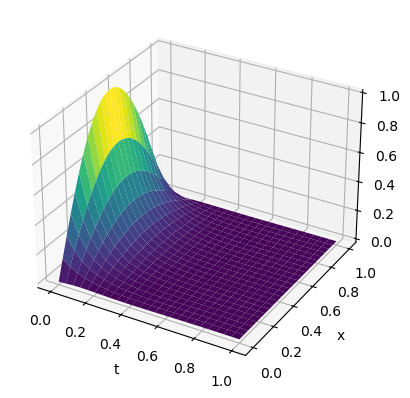

In [38]:
plot_3d_and_save(X, Y, Z_best_model, "../figuras/heat_pinns.pdf")

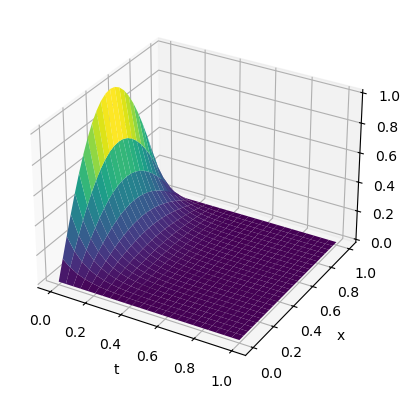

In [39]:
plot_3d_and_save(X, Y, Z_exact_sol, "../figuras/heat_exato.pdf")

## Analisando função de perda

In [40]:
def plot_and_save_losses(losshistory, file_path):
    
    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)

    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

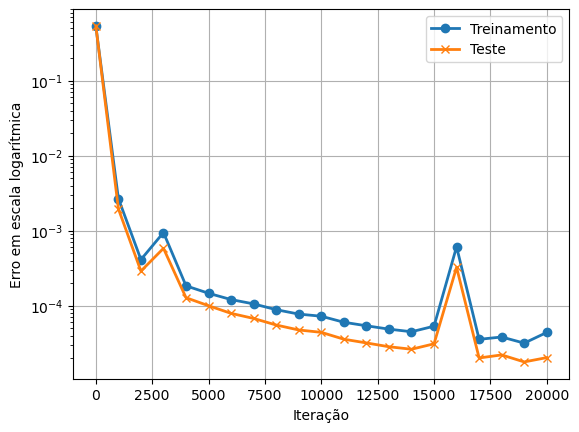

In [41]:
plot_and_save_losses(best_model.losshistory, "../figuras/heat_loss.pdf") 